In [1]:
import gymnasium as gym
import ale_py
import pickle
import numpy as np
import torch
from typing import List, Dict, Any, Tuple, Optional
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial.distance import directed_hausdorff
from sklearn.neighbors import NearestNeighbors
import torch.nn as nn
from sklearn.decomposition import PCA
import cv2
from scipy.ndimage import gaussian_filter
import os
import time
import itertools
import json
import random
from collections import defaultdict
from pathlib import Path
import argparse
from stable_baselines3 import PPO
from stable_baselines3.common.atari_wrappers import AtariWrapper
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, VecTransposeImage
from huggingface_sb3 import load_from_hub
from stable_baselines3.common.env_util import make_atari_env

from unlearning import evaluate_unlearning,  evaluate
from RetainSetGenerator import RetainSetGenerator

def make_atari_env(env_id="PongNoFrameskip-v4"):
    """Create a preprocessed Atari environment."""
    def make_env():
        env = gym.make(env_id, render_mode='rgb_array')
        env = AtariWrapper(env, clip_reward=False, terminal_on_life_loss=False)
        return env
    
    env = DummyVecEnv([make_env])
    env = VecTransposeImage(env)
    env = VecFrameStack(env, n_stack=4)
    return env

def load_ppo_from_hub(env_id="PongNoFrameskip-v4", env=None):
    """Load the PPO model directly from Hugging Face."""
    # Define the model path on Hugging Face
    repo_id = f"sb3/ppo-{env_id}"
    filename = f"ppo-{env_id}.zip"  # Standard filename for PPO models on Hugging Face
    
    print(f"Loading model from Hugging Face: {repo_id}")
    
    try:
        # Download and load the checkpoint
        checkpoint_path = load_from_hub(
            repo_id=repo_id,
            filename=filename
        )
        
        # Load the model
        model = PPO.load(
        checkpoint_path,
        env=env,
        custom_objects={
        # all ReplayBuffer arguments end up here
        "replay_buffer_kwargs": {"handle_timeout_termination": False}
        },
        device="cuda:3"          # or "cuda:2"
        )
        print(f"Model loaded successfully from {checkpoint_path}")
        policy = model.policy
        print(f"Policy type: {type(policy)}")
        print(f"Architecture: {policy.features_extractor}")
        
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        print(f"Verify that the model exists on Hugging Face: {repo_id}")
        raise
  
def to_serialisable(obj):
    """Helper to convert non‑JSON‑serialisable objects (e.g. NumPy arrays) to Python lists."""
    try:
        import numpy as np

        if isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        if isinstance(obj, (np.generic, np.number)):
            return obj.item()  # or float(obj)
    except ImportError:
        pass  # numpy not available / not needed
    # Let the default encoder handle (will raise TypeError if still unserialisable)
    raise TypeError(f"Object of type {type(obj)} is not JSON serialisable")

/home/microway/anaconda3/envs/manuel/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random.seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)


In [3]:
env_id = "PongNoFrameskip-v4"
env = make_atari_env(env_id)
agent = load_ppo_from_hub(env_id=env_id, env=env)

A.L.E: Arcade Learning Environment (version 0.11.0+dfae0bd)
[Powered by Stella]


Caricamento del modello da Hugging Face: sb3/ppo-PongNoFrameskip-v4


/home/microway/anaconda3/envs/manuel/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object learning_rate. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/home/microway/anaconda3/envs/manuel/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/home/microway/anaconda3/envs/manuel/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/home/microway/anaconda3/envs/manuel/lib/python3.10/site-packages/glfw/__in

Modello caricato con successo da /home/microway/.cache/huggingface/hub/models--sb3--ppo-PongNoFrameskip-v4/snapshots/55ac4cb4184f0d529eeef49fcee3926b4a7aa4af/ppo-PongNoFrameskip-v4.zip
Tipo di policy: <class 'stable_baselines3.common.policies.ActorCriticCnnPolicy'>
Architettura: NatureCNN(
  (cnn): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (linear): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
  )
)


/home/microway/anaconda3/envs/manuel/lib/python3.10/site-packages/stable_baselines3/common/base_class.py:751: UserWarning: You are probably loading a A2C/PPO model saved with SB3 < 1.7.0, we deactivated exact_match so you can save the model again to avoid issues in the future (see https://github.com/DLR-RM/stable-baselines3/issues/1233 for more info). Original error: Error(s) in loading state_dict for ActorCriticCnnPolicy:
	Missing key(s) in state_dict: "pi_features_extractor.cnn.0.weight", "pi_features_extractor.cnn.0.bias", "pi_features_extractor.cnn.2.weight", "pi_features_extractor.cnn.2.bias", "pi_features_extractor.cnn.4.weight", "pi_features_extractor.cnn.4.bias", "pi_features_extractor.linear.0.weight", "pi_features_extractor.linear.0.bias", "vf_features_extractor.cnn.0.weight", "vf_features_extractor.cnn.0.bias", "vf_features_extractor.cnn.2.weight", "vf_features_extractor.cnn.2.bias", "vf_features_extractor.cnn.4.weight", "vf_features_extractor.cnn.4.bias", "vf_features_extra

In [4]:



states_n = 500
forget_states = []
seed = -1
while len(forget_states) != states_n:   
    forget_states = []
    forget_actions = []
    seed += 1
    env.venv.seed(seed)
    state= env.reset()

    for step in range(1500):
        # Store state
        forget_states.append(state.copy())
        #env_state = env.unwrapped.sim.get_state()
        #env_states.append(env_state)
        # Policy action
        action= agent.predict(state, deterministic=True)[0]
                    
        # Store action
        forget_actions.append(action.copy() if isinstance(action, np.ndarray) else action)
                    
        # Step environment
        next_state, reward, done, _ = env.step(action)

    
        state = next_state
    
                    
        if done:
            break
            
    forget_states = np.array(forget_states)
    forget_actions = np.array(forget_actions)
    if len(forget_states) < states_n + 10:
        continue
    s = random.randint(10, len(forget_states)- states_n)
    forget_states = forget_states[s:s+ states_n].squeeze(1)
    forget_actions = forget_actions[s:s+ states_n].squeeze(1)
    print(len(forget_states))

500


In [5]:
estimator = RetainSetGenerator(
                        agent=agent, 
                        environment=env,
                        forget_states=forget_states,
                        similarity_threshold=0.001,
                        embedding_dim=512
                    )
retain_states, retain_actions = estimator.estimate_retain_set_via_environment(n_trajectories=50, max_steps=2000, random_action_prob=0.001)
retain_states = retain_states.squeeze(1)
retain_actions = retain_actions.squeeze(1)

Created default feature extractor with output dimension 512
Filtering generated states to maintain min_distance=0.001 from forget states
Setting up distance filter with similarity_threshold=0.001
Computing embeddings for 500 forget states...


/home/microway/anaconda3/envs/manuel/lib/python3.10/site-packages/cupy/_environment.py:541: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


Generating retain set by rolling out trajectories in the environment...
Trajectory 1/50 - Collected 0 valid states out of 0 total states
Trajectory 2/50 - Collected 1159 valid states out of 1668 total states
Trajectory 3/50 - Collected 2806 valid states out of 3320 total states
Trajectory 4/50 - Collected 4449 valid states out of 4968 total states
Trajectory 5/50 - Collected 6091 valid states out of 6615 total states
Trajectory 6/50 - Collected 7738 valid states out of 8268 total states
Trajectory 7/50 - Collected 9379 valid states out of 9914 total states
Trajectory 8/50 - Collected 11022 valid states out of 11562 total states
Trajectory 9/50 - Collected 12183 valid states out of 13232 total states
Trajectory 10/50 - Collected 13830 valid states out of 14884 total states
Trajectory 11/50 - Collected 15472 valid states out of 16531 total states
Trajectory 12/50 - Collected 17111 valid states out of 18177 total states
Trajectory 13/50 - Collected 18754 valid states out of 19827 total st

In [6]:
def unlearn_policy_kl(agent, forget_states, forget_actions, retain_states=None, retain_actions=None,
                                method='proportional', temperature=100.0, lambda1=0.1, lambda2=0.05,
                                num_epochs=50, lr=0.0001, lr_decay=0.95, min_lr=1e-6, 
                                max_grad_norm=1.0, clip_q_values=True, q_scale_factor=0.001,
                                evaluate=True, device=None, debug=False):
    """
    Unlearn specific state-action pairs using a pure full batch approach for maximum stability
    
    Args:
        agent: The CQL agent to modify
        forget_states: Image states to forget
        forget_actions: Actions to forget for these states
        retain_states: Image states to retain (optional)
        retain_actions: Actions for retain states (optional)
        method: Action redistribution method ('proportional', 'uniform')
        temperature: Temperature parameter for softmax conversion
        lambda1: Weight for forget loss
        lambda2: Weight for retain loss
        num_epochs: Number of training epochs
        lr: Initial learning rate
        lr_decay: Learning rate decay per epoch
        min_lr: Minimum learning rate
        max_grad_norm: Maximum norm for gradient clipping
        clip_q_values: Whether to scale down Q-values for numerical stability
        q_scale_factor: Factor to scale Q-values if clip_q_values is True
        evaluate: Whether to evaluate unlearning after training
        device: Device to use (if None, will auto-detect)
        debug: Whether to print debug information
        
    Returns:
        agent: The modified agent
        metrics: Evaluation metrics (if evaluate=True)
    """
    # Determine device
    if device is None:
        device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Access the Q-function based on agent type
    if hasattr(agent, "policy") and hasattr(agent.policy, "q_net"):
        # For DQN-like algorithms
        q_function = agent.policy.q_net
        print(f"Using Q-function from DQN-like agent: {type(q_function).__name__}")
    elif hasattr(agent, "policy") and hasattr(agent.policy, "qf1"):
        # For SAC/TD3-like algorithms with twin Q-functions
        q_function = agent.policy.qf1  # Use first Q-function
        print(f"Using Q-function from SAC/TD3-like agent: {type(q_function).__name__}")
    elif hasattr(agent, "policy") and hasattr(agent.policy, "action_net"):
        q_function = agent.policy
    else:
        print("Warning: Unable to identify Q-function in Stable Baselines agent")
        return agent, {"error": "No accessible Q-function found"}
    
    # Set to evaluation mode
    
    
    for param in q_function.parameters():
        param.requires_grad = False

    params_to_train = []
    for param in q_function.action_net.parameters():
        param.requires_grad = True
        params_to_train.append(param)

    for param in q_function.pi_features_extractor.linear.parameters():
        param.requires_grad = True
        params_to_train.append(param)
    
    # Helper function to extract q_values safely
    def extract_q_values(output):
        if hasattr(output, 'q_value'):
            q_values = output.q_value
        else:
            q_values = output
            
        # Optionally scale down large Q-values for numerical stability
        if clip_q_values:
            q_values = q_values * q_scale_factor
            
        return q_values
    
    # Helper function to compute target distributions
    def compute_target_distributions(probs, actions, method='proportional'):
        target_probs = torch.zeros_like(probs)
        print(probs)
        for i, (p, action) in enumerate(zip(probs, actions)):
            if method == 'proportional':
                mass_to_redistribute = p[action].item()
                num_remaining_actions = len(p) - 1
                mass_per_action = mass_to_redistribute / num_remaining_actions
                target_probs[i] = p.clone()
                target_probs[i][action] = 0.00001
            
                for j in range(len(p)):
                    if j != action:
                        target_probs[i][j] += mass_per_action
            
            elif method == 'uniform':
                # Uniform redistribution to all other actions
                uniform_probs = torch.ones_like(p)
                uniform_probs[action] = 0.00001
                target_probs[i] = uniform_probs / torch.sum(uniform_probs)
        print(target_probs)
        return target_probs
    
    # Convert to tensors - all at once for full batch processing
    forget_states_tensor = torch.tensor(forget_states, dtype=torch.float32, device=device)
    forget_actions_tensor = torch.tensor(forget_actions, dtype=torch.long, device=device)
    
    # Pre-compute original probabilities for retain states (if any)
    if retain_states is not None:
        print("Pre-computing original probabilities for retain states...")
        retain_states_tensor = torch.tensor(retain_states, dtype=torch.float32, device=device)
        
        with torch.no_grad():
            original_retain_dist = agent.policy.get_distribution(retain_states_tensor)
            # Salva i logits o le probabilità, non l'oggetto distribuzione
    
            original_retain_probs = original_retain_dist.distribution.probs.clone().detach()

        print(f"Computed original probabilities for {len(original_retain_probs)} retain states")
    else:
        retain_states_tensor = None
        original_retain_probs = None
    
    # Setup optimizer
    optimizer = torch.optim.Adam(params_to_train, lr=lr, eps=1e-5)  # Increased epsilon for stability
    
    print(f"Starting pure full batch unlearning with {len(forget_states)} forget states")
    if retain_states is not None:
        print(f"and {len(retain_states)} retain states")
    print(f"Using {method} redistribution method with temperature {temperature}")
    print(f"Learning will run for {num_epochs} epochs with learning rate {lr}")
    
    forget_distributions = agent.policy.get_distribution(forget_states_tensor)
    probs = forget_distributions.distribution.probs
    original_forget_probs = forget_distributions.distribution.probs
    target_probs = compute_target_distributions(probs.detach(), forget_actions_tensor, method)
    target_probs = torch.distributions.Categorical(probs=target_probs)
    print(probs, target_probs.probs )
    # Initialize loss tracking
    losses = {'total': [], 'forget': [], 'retain': []}
    
    # Main training loop
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Process all forget states at once
        try:
            # Forward pass for forget states
            
           
            current_forget_probs = agent.policy.get_distribution(forget_states_tensor)
            
            forget_loss = torch.distributions.kl_divergence(current_forget_probs.distribution, target_probs).mean()
          
            if retain_states_tensor is not None and original_retain_probs is not None and epoch % 1 == 0:
                # Forward pass for retain states
                
                current_retain_probs = agent.policy.get_distribution(retain_states_tensor)

                original_dist = torch.distributions.Categorical(probs=original_retain_probs)
                
                retain_loss = torch.distributions.kl_divergence(current_retain_probs.distribution, original_dist).mean()
                
                
            
            # Compute total loss with weights
           
            total_loss = lambda1 * forget_loss + lambda2 * retain_loss
            
            # Backpropagation
            total_loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(params_to_train, max_grad_norm)
            
            # Check for NaN or Inf in gradients

            has_nan_grad = False
           
            
            if not has_nan_grad:
                # Update parameters
                optimizer.step()
            else:
                print(f"Skipping parameter update on epoch {epoch+1} due to NaN/Inf in gradients")
            
            # Store losses
            losses['forget'].append(forget_loss.item())
            losses['retain'].append(retain_loss.item())
            losses['total'].append(total_loss.item())
            
            # Update learning rate
            current_lr = optimizer.param_groups[0]['lr']
            optimizer.param_groups[0]['lr'] = max(current_lr * lr_decay, min_lr)
            
            # Log progress
            if (epoch + 1) % 1 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{num_epochs}: "
                      f"Total Loss = {total_loss.item():.4f}, "
                      f"Forget Loss = {forget_loss.item():.4f}, "
                      f"Retain Loss = {retain_loss.item():.20f}, "
                      f"LR = {current_lr:.6f}")
                
                
                    
        except Exception as e:
            print(f"Error on epoch {epoch+1}: {e}")
            continue
    
    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(losses['total'], label='Total Loss')
    plt.plot(losses['forget'], label='Forget Loss (KL Divergence)')
    plt.plot(losses['retain'], label='Retain Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    # Evaluate if requested
    if evaluate:
        metrics = evaluate_unlearning(agent, forget_states, forget_actions, 
                                    retain_states, retain_actions, original_retain_probs=original_retain_probs,
                                    target_forget_probs=target_probs.probs, original_forget_probs= original_forget_probs,
                                    temperature=temperature, device=device,
                                    q_scale_factor=q_scale_factor if clip_q_values else 1.0)
        return agent, metrics, original_retain_probs, original_forget_probs, target_probs.probs
    
    return agent, None, None, None, None

Using device: cuda:3
Pre-computing original probabilities for retain states...
Computed original probabilities for 79150 retain states
Starting pure full batch unlearning with 500 forget states
and 79150 retain states
Using proportional redistribution method with temperature 1
Learning will run for 1000 epochs with learning rate 0.0005
tensor([[0.1039, 0.0852, 0.5196, 0.2655, 0.0114, 0.0143],
        [0.0625, 0.0886, 0.5853, 0.2304, 0.0084, 0.0249],
        [0.0562, 0.1211, 0.4073, 0.2805, 0.0197, 0.1151],
        ...,
        [0.0432, 0.2536, 0.2372, 0.1142, 0.1251, 0.2269],
        [0.0217, 0.0519, 0.0234, 0.0798, 0.7907, 0.0324],
        [0.0863, 0.0672, 0.0512, 0.2323, 0.5108, 0.0523]], device='cuda:3')
tensor([[2.0783e-01, 1.8916e-01, 1.0000e-05, 3.6941e-01, 1.1536e-01, 1.1824e-01],
        [1.7954e-01, 2.0566e-01, 1.0000e-05, 3.4742e-01, 1.2544e-01, 1.4194e-01],
        [1.3769e-01, 2.0260e-01, 1.0000e-05, 3.6199e-01, 1.0119e-01, 1.9653e-01],
        ...,
        [9.3874e-02, 1.0

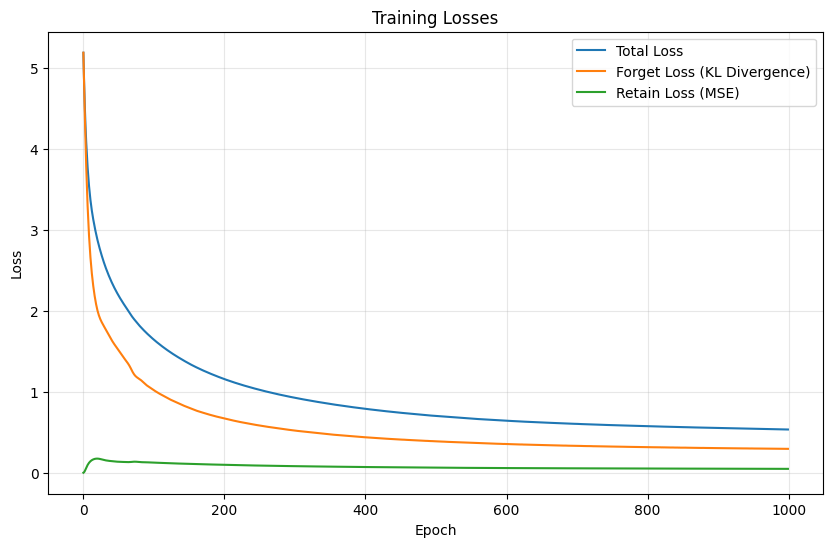

Computing action probabilities for forget states...
tensor([[0.1039, 0.0852, 0.5196, 0.2655, 0.0114, 0.0143],
        [0.0625, 0.0886, 0.5853, 0.2304, 0.0084, 0.0249],
        [0.0562, 0.1211, 0.4073, 0.2805, 0.0197, 0.1151],
        ...,
        [0.0432, 0.2536, 0.2372, 0.1142, 0.1251, 0.2269],
        [0.0217, 0.0519, 0.0234, 0.0798, 0.7907, 0.0324],
        [0.0863, 0.0672, 0.0512, 0.2323, 0.5108, 0.0523]], device='cuda:3',
       grad_fn=<SoftmaxBackward0>)

Discrete Action Unlearning Evaluation

📊 Forget States (n=500):
  Forget action no longer most likely: 98.80%
  Average prob of forget actions: 0.0211
  Average prob of best alternatives: 0.3740
  Average prob ratio (forget/best_alt): 12060684.0000

  Normalized Distance to Target:
    Mean: 0.1827 ± 0.2423
    Range: [0.0037, 1.0000]
    Distance Accuracy: 11.6% (58/500 > 0.5)

📊 Retain States Evaluation:
  Retain action still most likely: 90.63%
  Average prob of retain actions: 0.5106

  Normalized Distance from Original:
  

In [7]:
modified_agent, metrics, original_retain_probs, original_forget_probs, target_probs = unlearn_policy_kl(
    agent=agent,
    forget_states=forget_states,
    forget_actions=forget_actions,
    retain_states=retain_states,
    retain_actions=retain_actions,
    method='proportional',
    temperature=1,      # Temperatura alta per stabilità
    lambda1=1,            # Peso inferiore per stabilità
    lambda2=5,           # Peso inferiore per stabilità
    num_epochs=1000,          # Meno epoche con full batch
    lr=0.0005,              # Learning rate basso
    min_lr=0.0005,
    max_grad_norm=5.0,      # Gradient clipping
    clip_q_values=True,     # Scala i Q-values
    q_scale_factor=1,  # Fattore di scala
    device="cuda:3"
)

In [8]:
retain_probs_before = original_retain_probs

retain_tensor = torch.tensor(retain_states, dtype=torch.float32, device=agent.device)
forget_tensor = torch.tensor(forget_states, dtype=torch.float32, device=agent.device)

retain_probs_after = agent.policy.get_distribution(retain_tensor).distribution.probs

forget_probs_before = original_forget_probs

forget_probs_after = agent.policy.get_distribution(forget_tensor).distribution.probs
      

In [10]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



# 1. Combine all data

retain_probs_before = retain_probs_before.detach().cpu().numpy()  # or .cpu().detach().numpy() if requires gradients
retain_probs_after = retain_probs_after.detach().cpu().numpy()
forget_probs_before = forget_probs_before.detach().cpu().numpy()
forget_probs_after = forget_probs_after.detach().cpu().numpy()



# Sampling parameters
n_samples = 20  # number of samples per type
np.random.seed(42)  # for reproducibility

# Sample retain states
n_retain_total = len(retain_probs_before)
n_retain_sample = min(n_samples, n_retain_total)
retain_indices = np.random.choice(n_retain_total, n_retain_sample, replace=False)
retain_probs_before_sample = retain_probs_before[retain_indices]
retain_probs_after_sample = retain_probs_after[retain_indices]

# Sample forget states
n_forget_total = len(forget_probs_before)
n_forget_sample = min(n_samples, n_forget_total)
forget_indices = np.random.choice(n_forget_total, n_forget_sample, replace=False)
forget_probs_before_sample = forget_probs_before[forget_indices]
forget_probs_after_sample = forget_probs_after[forget_indices]

# Combine all sampled data
all_probs = np.vstack([
    retain_probs_before_sample,
    retain_probs_after_sample,
    forget_probs_before_sample,
    forget_probs_after_sample
])

# Apply t-SNE
tsne = TSNE(
    n_components=2, 
    random_state=42, 
    perplexity=30,          
    early_exaggeration=16,  
    learning_rate=300,
    n_iter=2000,
    metric='euclidean'
)
embedded = tsne.fit_transform(all_probs)

# Optional: scale further
embedded = embedded * 1.5

# Separate embedded points
retain_before = embedded[:n_retain_sample]
retain_after = embedded[n_retain_sample:2*n_retain_sample]
forget_before = embedded[2*n_retain_sample:2*n_retain_sample+n_forget_sample]
forget_after = embedded[2*n_retain_sample+n_forget_sample:]

/home/microway/anaconda3/envs/manuel/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


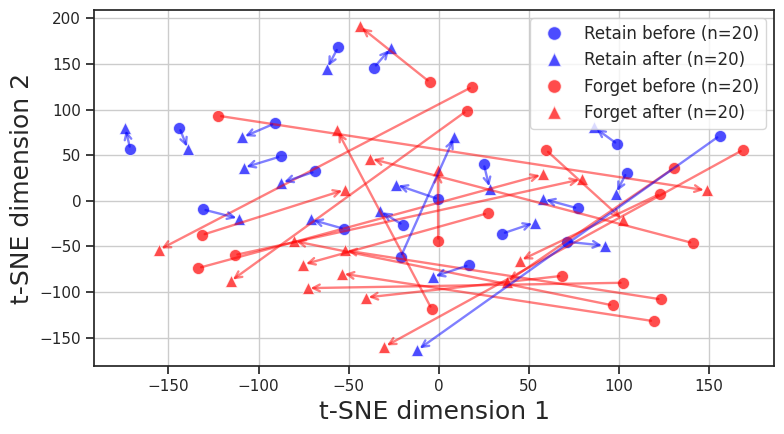

Campionati 20/79150 retain states
Campionati 20/500 forget states


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set seaborn style
sns.set_theme(style="ticks")

# Create a DataFrame to facilitate plotting with seaborn
data_list = []

# Add retain data
for i in range(n_retain_sample):
    data_list.append({
        'x': retain_before[i, 0],
        'y': retain_before[i, 1],
        'category': 'Retain',
        'time': 'Before',
        'label': f'Retain before (n={n_retain_sample})'
    })
    data_list.append({
        'x': retain_after[i, 0],
        'y': retain_after[i, 1],
        'category': 'Retain',
        'time': 'After',
        'label': f'Retain after (n={n_retain_sample})'
    })

# Add forget data
for i in range(n_forget_sample):
    data_list.append({
        'x': forget_before[i, 0],
        'y': forget_before[i, 1],
        'category': 'Forget',
        'time': 'Before',
        'label': f'Forget before (n={n_forget_sample})'
    })
    data_list.append({
        'x': forget_after[i, 0],
        'y': forget_after[i, 1],
        'category': 'Forget',
        'time': 'After',
        'label': f'Forget after (n={n_forget_sample})'
    })

df = pd.DataFrame(data_list)

# Create the plot
plt.figure(figsize=(8, 4.5))

# Define colors and markers
palette = {'Retain': 'blue', 'Forget': 'red'}
markers = {'Before': 'o', 'After': '^'}

# Plot using seaborn
for category in ['Retain', 'Forget']:
    for time in ['Before', 'After']:
        data_subset = df[(df['category'] == category) & (df['time'] == time)]
        if len(data_subset) > 0:
            label = data_subset.iloc[0]['label']
            sns.scatterplot(data=data_subset, x='x', y='y', 
                          color=palette[category], 
                          marker=markers[time],
                          s=75, alpha=0.7, label=label,
                          legend=False)

# Add arrows for a subset of points
n_arrows = min(50, n_forget_sample)

# Arrows for forget states
arrow_indices = np.random.choice(n_forget_sample, n_arrows, replace=False)
for i in arrow_indices:
    plt.annotate('', xy=(forget_after[i, 0], forget_after[i, 1]),
                xytext=(forget_before[i, 0], forget_before[i, 1]),
                arrowprops=dict(arrowstyle='->', color='red', lw=1.7, alpha=0.5))

# Arrows for retain states    
arrow_indices = np.random.choice(n_retain_sample, n_arrows, replace=False)
for i in arrow_indices:
    plt.annotate('', xy=(retain_after[i, 0], retain_after[i, 1]),
                xytext=(retain_before[i, 0], retain_before[i, 1]),
                arrowprops=dict(arrowstyle='->', color='blue', lw=1.7, alpha=0.5))

# Customize the plot
plt.xlabel('t-SNE dimension 1', fontsize=18)
plt.ylabel('t-SNE dimension 2', fontsize=18)

# Create legend manually for complete control
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
           markersize=10, alpha=0.7, label=f'Retain before (n={n_retain_sample})'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='blue', 
           markersize=10, alpha=0.7, label=f'Retain after (n={n_retain_sample})'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
           markersize=10, alpha=0.7, label=f'Forget before (n={n_forget_sample})'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='red', 
           markersize=10, alpha=0.7, label=f'Forget after (n={n_forget_sample})')
]
plt.legend(handles=legend_elements, fontsize=12)

# Remove seaborn's darker grid background if you prefer
#sns.despine()
plt.grid(True)
plt.tight_layout()
plt.savefig("/home/user/experiments/atari/experiments/tsne.pdf", 
            format='pdf', bbox_inches="tight")
plt.show()

# Print info
print(f"Sampled {n_retain_sample}/{n_retain_total} retain states")
print(f"Sampled {n_forget_sample}/{n_forget_total} forget states")

=== DISPLACEMENT ANALYSIS ===

Retain Actions:
  Mean displacement: 42.2659
  Std displacement:  61.5347
  Min displacement:  20.0655
  Max displacement:  288.6559

Forget Actions:
  Mean displacement: 171.9893
  Std displacement:  65.3718
  Min displacement:  72.6161
  Max displacement:  293.7963

=== STATISTICAL TEST ===
T-test (forget vs retain):
  t-statistic: 6.2984
  p-value: 0.0000
  → Forget actions hanno displacement SIGNIFICATIVAMENTE maggiore


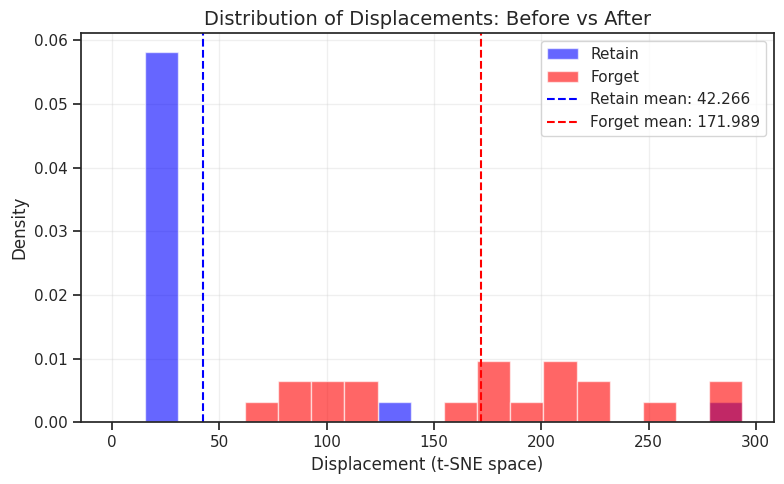


=== DIRECTIONAL DISPLACEMENT ===
Retain mean displacement vector: [-12.0410, -7.0572]
Forget mean displacement vector: [-54.0675, -9.1810]

Angolo tra i vettori di displacement medio: 20.74°


In [15]:
import numpy as np
from sklearn.manifold import TSNE


# Calculate displacement for each point (euclidean distance between before and after)
def calculate_displacements(before_points, after_points):
    """
    Calculate individual displacements between before and after positions
    """
    displacements = np.sqrt(np.sum((after_points - before_points)**2, axis=1))
    return displacements

# Calculate displacement for retain actions
retain_displacements = calculate_displacements(retain_before, retain_after)
retain_displacement_mean = np.mean(retain_displacements)
retain_displacement_std = np.std(retain_displacements)

# Calculate displacement for forget actions  
forget_displacements = calculate_displacements(forget_before, forget_after)
forget_displacement_mean = np.mean(forget_displacements)
forget_displacement_std = np.std(forget_displacements)


print("=== DISPLACEMENT ANALYSIS ===")
print(f"\nRetain Actions:")
print(f"  Mean displacement: {retain_displacement_mean:.4f}")
print(f"  Std displacement:  {retain_displacement_std:.4f}")
print(f"  Min displacement:  {np.min(retain_displacements):.4f}")
print(f"  Max displacement:  {np.max(retain_displacements):.4f}")

print(f"\nForget Actions:")
print(f"  Mean displacement: {forget_displacement_mean:.4f}")
print(f"  Std displacement:  {forget_displacement_std:.4f}")
print(f"  Min displacement:  {np.min(forget_displacements):.4f}")
print(f"  Max displacement:  {np.max(forget_displacements):.4f}")

# Statistical test to see if there's significant difference
from scipy import stats
t_stat, p_value = stats.ttest_ind(forget_displacements, retain_displacements)
print(f"\n=== STATISTICAL TEST ===")
print(f"T-test (forget vs retain):")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")

if p_value < 0.05:
    if forget_displacement_mean > retain_displacement_mean:
        print("  → Forget actions have SIGNIFICANTLY greater displacement")
    else:
        print("  → Retain actions have SIGNIFICANTLY greater displacement")
else:
    print("  → No significant difference in displacements")

# Optional visualization: displacement histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
bins = np.linspace(0, max(np.max(retain_displacements), np.max(forget_displacements)), 20)

plt.hist(retain_displacements, bins=bins, alpha=0.6, label='Retain', color='blue', density=True)
plt.hist(forget_displacements, bins=bins, alpha=0.6, label='Forget', color='red', density=True)

plt.axvline(retain_displacement_mean, color='blue', linestyle='--', 
            label=f'Retain mean: {retain_displacement_mean:.3f}')
plt.axvline(forget_displacement_mean, color='red', linestyle='--', 
            label=f'Forget mean: {forget_displacement_mean:.3f}')

plt.xlabel('Displacement (t-SNE space)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Displacements: Before vs After', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate also directional mean displacement (mean vector)
print("\n=== DIRECTIONAL DISPLACEMENT ===")
retain_vector_displacements = retain_after - retain_before
forget_vector_displacements = forget_after - forget_before

retain_mean_vector = np.mean(retain_vector_displacements, axis=0)
forget_mean_vector = np.mean(forget_vector_displacements, axis=0)

print(f"Retain mean displacement vector: [{retain_mean_vector[0]:.4f}, {retain_mean_vector[1]:.4f}]")
print(f"Forget mean displacement vector: [{forget_mean_vector[0]:.4f}, {forget_mean_vector[1]:.4f}]")

# Angle between mean displacement vectors
cos_angle = np.dot(retain_mean_vector, forget_mean_vector) / (np.linalg.norm(retain_mean_vector) * np.linalg.norm(forget_mean_vector))
angle_degrees = np.arccos(np.clip(cos_angle, -1, 1)) * 180 / np.pi
print(f"\nAngle between mean displacement vectors: {angle_degrees:.2f}°")